In [ ]:
import torch as trc, matplotlib.pyplot as plt, numpy as np
import cv2
from imutils import paths

import torchvision.transforms.functional as TF

import torchvision
from torchvision import transforms, models
from tqdm import tqdm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, jaccard_score

# Data Preparation and Review

In [ ]:
!unzip -q drive/MyDrive/VKR/data_seg_200.zip

In [ ]:
size, sharpness = 256, 10

read_img = transforms.Compose([
  transforms.ToPILImage(),
  transforms.Resize((size, size)),
  transforms.ToTensor(),

  transforms.Grayscale(),
  transforms.RandomAdjustSharpness(sharpness, 1),

  # transforms.Normalize(mean, std),
])

In [ ]:
imagePaths = sorted(list(paths.list_images('data/images')))
maskPaths = sorted(list(paths.list_images('data/masks')))

train_X, test_X, train_y, test_y = train_test_split(imagePaths, maskPaths,
                                                    test_size=0.15,
                                                    random_state=0)

len(train_X), len(train_y), len(test_X), len(test_y)

(170, 170, 30, 30)

In [ ]:
class SegmentationDataset(trc.utils.data.Dataset):
  def __init__(self, imgPaths, mskPaths, transforms=None, apply_aug=False):
    self.imgPaths, self.mskPaths = imgPaths, mskPaths
    self.transforms, self.apply_aug = transforms, apply_aug

  def __len__(self):
    return len(self.imgPaths)

  def augmentation(self, x, y):
    if np.random.uniform() > 0.5:
      x, y = TF.hflip(x), TF.hflip(y)
    if np.random.uniform() > 0.5:
      x, y = TF.vflip(x), TF.vflip(y)
    deg = np.random.randint(0, 181)
    x, y = TF.rotate(x, deg), TF.rotate(y, deg)
    return x, y
	
  def __getitem__(self, idx):
    # load the image from disk, (swap its ch from BGR to RGB),
    # and read the associated mask from disk in grayscale mode
    image = cv2.imread(self.imgPaths[idx])
    # image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    mask = cv2.imread(self.mskPaths[idx], 0)

    if self.transforms is not None:
      image, mask = self.transforms(image), self.transforms(mask)
    
    if self.apply_aug:
      image, mask = self.augmentation(image, mask)

    return image, mask

In [ ]:
dt_train = SegmentationDataset(train_X, train_y, read_img, True)
dt_test = SegmentationDataset(test_X, test_y, read_img)

len(dt_train), len(dt_test)

(170, 30)

In [ ]:
dt_train[0][0].shape, dt_train[0][1].shape

(torch.Size([1, 256, 256]), torch.Size([1, 256, 256]))

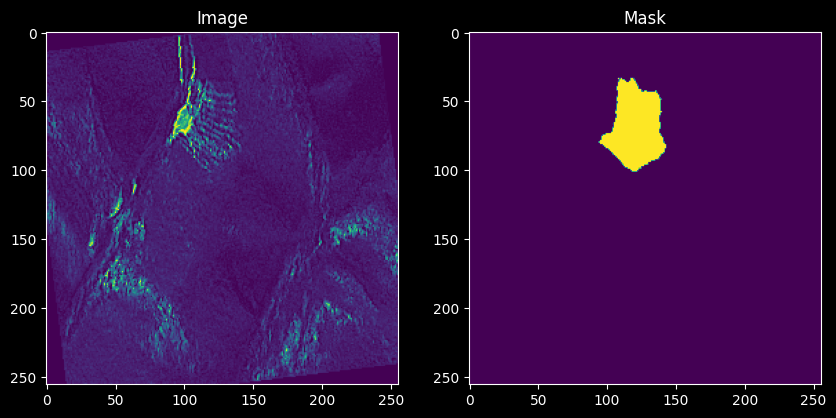

In [ ]:
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (10, 5)

image, mask = dt_train[0]

plt.subplot(121)
# plt.imshow(image.permute(1, 2, 0))
plt.imshow(image[0])
plt.title('Image')

plt.subplot(122)
plt.imshow(mask.squeeze())
plt.title('Mask');

In [ ]:
batch_size = 10

train_dl = trc.utils.data.DataLoader(dt_train, batch_size, shuffle=True,
                                     pin_memory=True, num_workers=2, drop_last=True)
test_dl = trc.utils.data.DataLoader(dt_test, len(dt_test),
                                    pin_memory=True, num_workers=2)

# Neural Net Class (U-net)

In [ ]:
class ConvBlock(trc.nn.Module):
  def __init__(self, in_ch, out_ch):
    super().__init__()
    self.conv3_1 = trc.nn.Conv2d(in_ch, out_ch, 3, padding=1)
    self.conv3_2 = trc.nn.Conv2d(out_ch, out_ch, 3, padding=1)
    self.act = trc.nn.ReLU()
  
  def forward(self, x):
    x = self.act(self.conv3_1(x))
    return self.act(self.conv3_2(x))

In [ ]:
class Encoder(trc.nn.Module):
  def __init__(self, ch=(3, 16, 32, 64)):
    super().__init__()
    blocks = [ConvBlock(ch[i], ch[i+1]) for i in range(len(ch)-1)]
    self.encBlocks = trc.nn.ModuleList(blocks)
    self.pool = trc.nn.MaxPool2d(2)
    self.act = trc.nn.ReLU()
  
  def forward(self, x):
    blockOutputs = []
    for block in self.encBlocks:
      x = block(x)
      blockOutputs.append(x)
      x = self.pool(x)
    # return the list containing the intermediate outputs
    return blockOutputs

In [ ]:
class Decoder(trc.nn.Module):
  def __init__(self, ch=(64, 32, 16)):
    super().__init__()
    upsamplers, decBlocks = [], []
    for i in range(len(ch)-1):
      upsamplers.append(trc.nn.ConvTranspose2d(ch[i], ch[i+1], 2, 2))
      decBlocks.append(ConvBlock(ch[i], ch[i+1]))
    
    self.ch = ch
    self.upsamplers = trc.nn.ModuleList(upsamplers)
    self.decBlocks = trc.nn.ModuleList(decBlocks)
	
  def forward(self, x, encFeatures):
    for i in range(len(self.ch) - 1):
      # pass the inputs through the current upsampler block
      x = self.upsamplers[i](x)

      # crop the current features from the encoder blocks (if needed),
      # concatenate them with the current upsampled features,
      # and pass the concatenated output through the current decoder block
      # encFeatures_for_cat = self.crop(encFeatures[i], x)
      x = trc.cat([x, encFeatures[i]], dim=1)
      x = self.decBlocks[i](x)
    return x
	
  def crop(self, encFeatures, x):
    _, _, h, w = x.shape
    res = transforms.CenterCrop([h, w])(encFeatures)
    return res

In [ ]:
class SegNet(trc.nn.Module):
  def __init__(self, encCH=(1, 16, 32, 64), decCH=(64, 32, 16),
               nClasses=1, retainDim=True, outSize=(256, 256)):
    super().__init__()
    self.retainDim, self.outSize = retainDim, outSize
    self.encoder, self.decoder = Encoder(encCH), Decoder(decCH)
    self.head = trc.nn.Conv2d(decCH[-1], nClasses, 1)
    self.act = trc.nn.Sigmoid()
  
  def forward(self, x):
    encFeatures = self.encoder(x)
    dec_res = self.decoder(encFeatures[-1], encFeatures[::-1][1:])
    mask = self.head(dec_res)
    # resize to match initial size if needed
    # trc.nn.functional.interpolate(mask, self.outSize)
    return self.act(mask)

# Net Init, Loss and Optimizer

In [ ]:
np.random.seed(1)
trc.manual_seed(1)
trc.cuda.manual_seed(1)
trc.backends.cudnn.determenistic = True

In [ ]:
device = ('cuda:0' if trc.cuda.is_available() else 'cpu')

net = SegNet().to(device)
loss = trc.nn.BCELoss()
optimizer = trc.optim.Adam(net.parameters(), lr=0.001, amsgrad=True)
# optimizer = trc.optim.NAdam(net.parameters(), lr=0.001)
# scheduler = trc.optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

device

'cuda:0'

# Learning

In [ ]:
train_loss_hist, train_accuracy_hist, train_jc_hist = [], [], []
test_loss_hist, test_accuracy_hist, test_jc_hist = [], [], []
max_acc, threshold = 0, 0.35
# lr_red, k = [0.8, 0.9], 0

for epoch in tqdm(range(20)):
  net.train()

  for i in range(0, len(dt_train), batch_size):
    acc_sum, acc_jc, loss_sum, batch_n = 0, 0, 0, 0

    for input, targets in train_dl:
      input = input.to(device)
      targets = targets.to(device)

      preds = net.forward(input)
      loss_val = loss(preds, targets)
      loss_val.backward()

      trg = (targets.reshape(-1).data >= 0.5).int().cpu()
      prd = (preds.reshape(-1).data >= threshold).int().cpu()
      # acc_sum += ((preds.data>=threshold).int() == targets).float().mean().cpu()
      acc_sum += (prd == trg).float().mean()
      acc_jc += jaccard_score(trg, prd, average='weighted')
      loss_sum += loss_val.data.cpu()
      batch_n += 1

      optimizer.step()
      optimizer.zero_grad()
  
  train_accuracy_hist.append(acc_sum/batch_n)
  train_jc_hist.append(acc_jc/batch_n)
  train_loss_hist.append(loss_sum/batch_n)
  net.eval()

  for input, targets in test_dl:
    input = input.to(device)
    targets = targets.to(device)

    with trc.set_grad_enabled(False):
      preds = net.forward(input).data
      loss_val = loss(preds, targets).data.cpu()
      # accuracy = ((preds.data>=threshold).int() == targets).float().mean().cpu()
      trg = (targets.reshape(-1).data >= 0.5).int().cpu()
      prd = (preds.reshape(-1).data >= threshold).int().cpu()
      accuracy = (prd == trg).float().mean()
      jc = jaccard_score(trg, prd, average='weighted')

    test_accuracy_hist.append(accuracy)
    test_jc_hist.append(jc)
    test_loss_hist.append(loss_val)

    if accuracy >= max_acc:
      trc.save(net, 'segmentation_model')
      max_acc = accuracy

    '''if k < len(lr_red) and accuracy > lr_red[k]:
      scheduler.step()
      k+=1'''

100%|██████████| 20/20 [40:40<00:00, 122.03s/it]


# Statistics

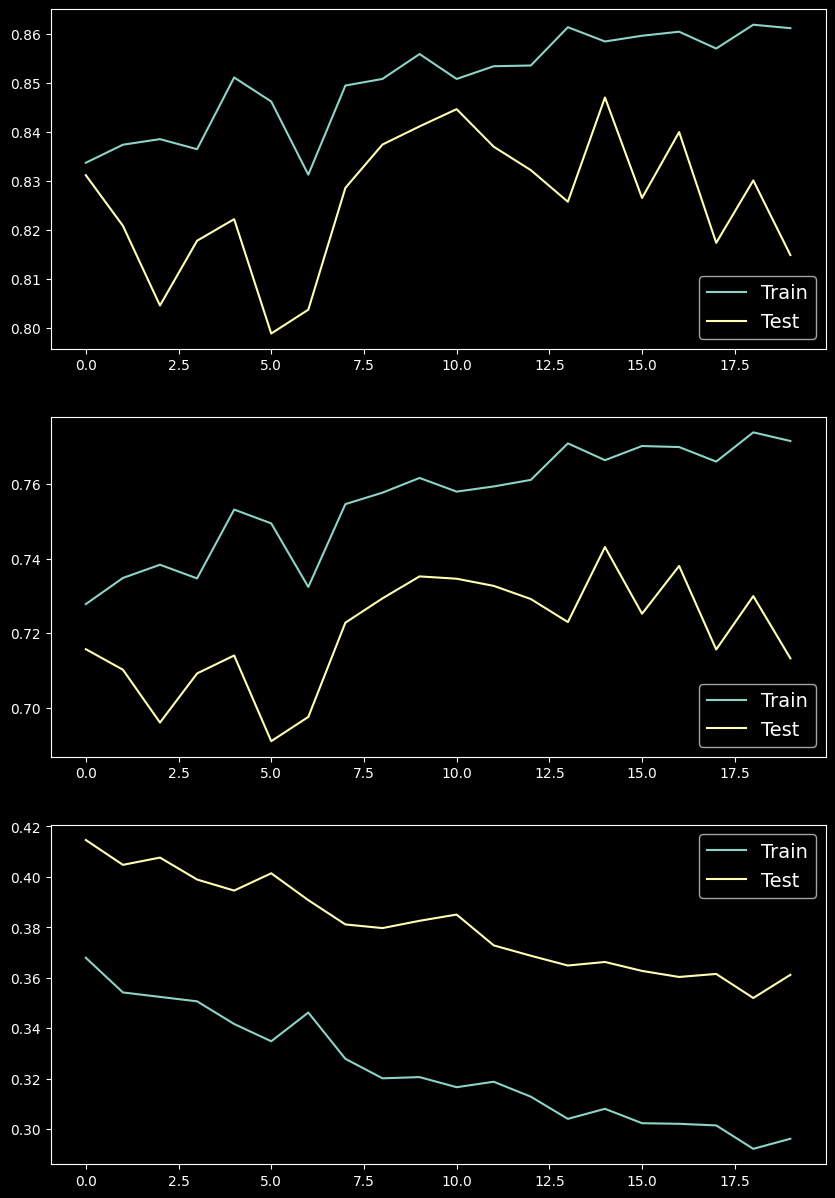

In [ ]:
# plt.style.use('dark_background')
fig, axs = plt.subplots(3)
fig.set_size_inches(10, 15)

axs[0].plot(train_accuracy_hist, label='Train')
axs[0].plot(test_accuracy_hist, label='Test')
axs[0].legend(fontsize=14, loc='lower right')

axs[1].plot(train_jc_hist, label='Train')
axs[1].plot(test_jc_hist, label='Test')
axs[1].legend(fontsize=14, loc='lower right')

axs[2].plot(train_loss_hist, label='Train')
axs[2].plot(test_loss_hist, label='Test')
axs[2].legend(fontsize=14);

In [ ]:
net_test = trc.load('segmentation_model')
net_test.to('cpu')
preds, targets = trc.tensor([]), trc.tensor([])

for X, y in test_dl:
  with trc.set_grad_enabled(False):
    res = net_test.forward(X).data

  preds = trc.cat([preds, res])
  targets = trc.cat([targets, y])

In [ ]:
trg = (targets.reshape(-1) >= 0.5).int()
prd = (preds.reshape(-1) >= 0.35).int()

print(jaccard_score(trg, prd, average=None))
print(jaccard_score(trg, prd, average='weighted'))

[0.8302958  0.39164659]
0.7431335481361494


In [ ]:
print(classification_report(trg, prd))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91   1575408
           1       0.65      0.50      0.56    390672

    accuracy                           0.85   1966080
   macro avg       0.77      0.71      0.74   1966080
weighted avg       0.84      0.85      0.84   1966080



# Testing

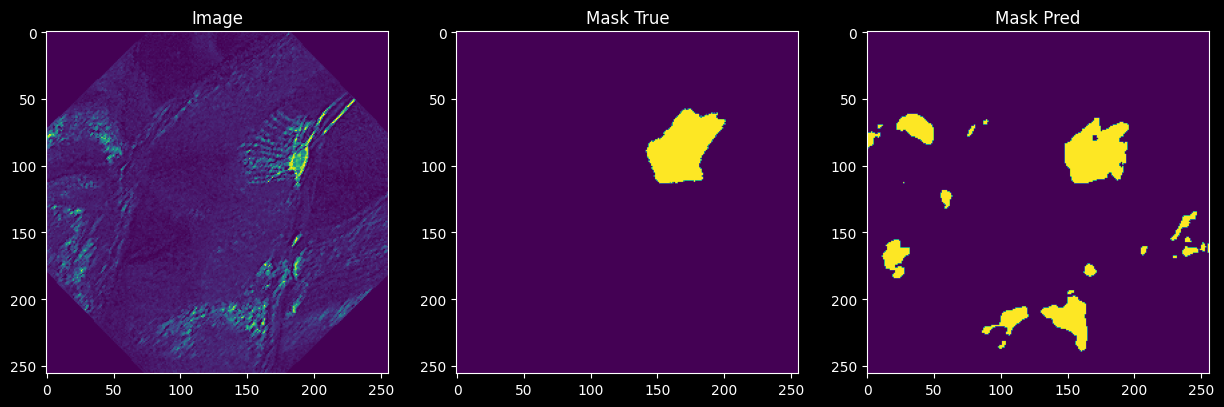

In [ ]:
net_test = trc.load('segmentation_model')
plt.rcParams['figure.figsize'] = (15, 5)

image, mask_true = dt_train[0]
pred = net_test.forward(image.unsqueeze(0).to(device)).data.cpu()

plt.subplot(131)
plt.imshow(image.permute(1, 2, 0))
plt.title('Image')

plt.subplot(132)
plt.imshow(mask_true.squeeze())
plt.title('Mask True')

plt.subplot(133)
plt.imshow((pred.squeeze() >= 0.1).int())
plt.title('Mask Pred');

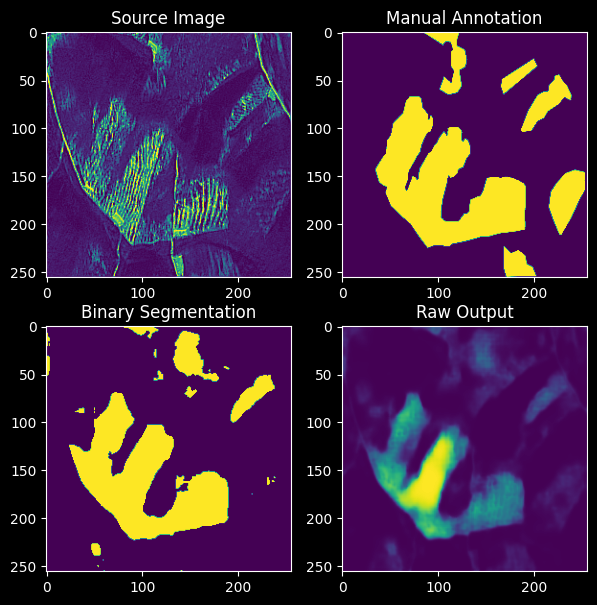

In [ ]:
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(7, 7)

image, mask_true = dt_test[0]
pred = net_test.forward(image.unsqueeze(0).to(device)).data.cpu()

axs[0][0].imshow(image[0])
axs[0][0].set_title('Source Image')
axs[0][1].imshow(mask_true[0])
axs[0][1].set_title('Manual Annotation')
axs[1][0].imshow((pred.squeeze() >= 0.1).int())
axs[1][0].set_title('Binary Segmentation')
axs[1][1].imshow(pred.squeeze())
axs[1][1].set_title('Raw Output');